In [10]:
import pandas as pd
from pandas.plotting import scatter_matrix
import scipy as sp
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, f1_score, classification_report
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

In [3]:
DATA_PATH = '/Users/gabriele/mydata/medium/medium_ai_ml_dl_posts_with_text.csv'

In [4]:
raw_df = pd.read_csv(DATA_PATH)
raw_df.head()

,user_username,article_url,image_count,post_tags,recommends,reading_time,title,text,link_count
0,ageitgey,https://medium.com/@ageitgey/machine-learning-...,12,"{""Machine Learning""}",4132,14.021698,Machine Learning is Fun!,"Update: Machine Learning is Fun! Part 2, Part ...",12
1,tonyaub,https://medium.com/swlh/no-ui-is-the-new-ui-ab...,12,"{Design,""Artificial Intelligence"",UI}",3666,7.787736,No UI is the New UI,On the rise of UI-less apps and why you should...,9
2,cdixon,https://medium.com/@cdixon/eleven-reasons-to-b...,32,"{Technology,""Artificial Intelligence"",Future,R...",3658,11.104717,Eleven Reasons To Be Excited About The Future ...,"In the year 1820, a person could expect to liv...",17
3,2noame,https://medium.com/basic-income/deep-learning-...,5,"{""Artificial Intelligence"",""Machine Learning"",...",3101,13.727673,Deep Learning Is Going to Teach Us All the Les...,(An alternate version of this article was orig...,64
4,perborgen,https://medium.com/learning-new-stuff/machine-...,3,"{""Machine Learning"",""Artificial Intelligence"",...",2709,6.716038,Machine Learning in a Year,This is a follow up to an article I wrote last...,10


In [23]:
raw_df.iloc[0].article_url

'https://medium.com/@ageitgey/machine-learning-is-fun-80ea3ec3c471'

### Basic Data Vizualition

In [8]:
medium_df = raw_df.dropna().copy()
medium_df.shape

(5710, 9)

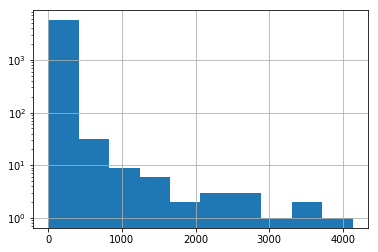

In [9]:
medium_df.recommends.hist(log=True);

In [43]:
def scatter_plot(col, threshold=None):
    if threshold is None:
        medium_df.plot.scatter(y=col, x='recommends')
    else:
        medium_df[medium_df[col] < threshold].plot.scatter(y=col, x='recommends')

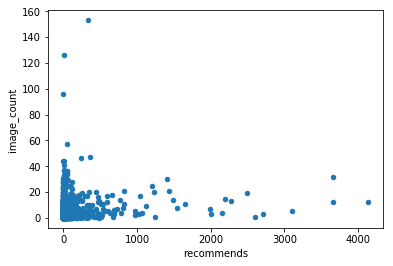

In [44]:
scatter_plot('image_count')

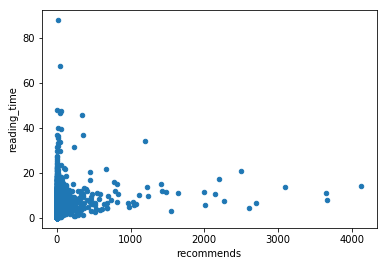

In [46]:
scatter_plot('reading_time')

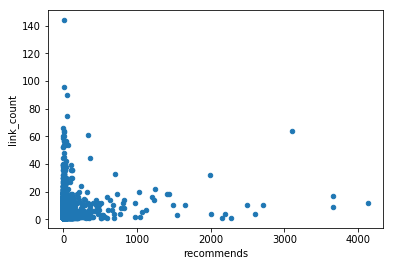

In [48]:
scatter_plot('link_count')

In [53]:
float(medium_df.shape[0]) / medium_df.user_username.nunique()

1.8690671031096564

In [71]:
agg_df = medium_df.groupby('user_username').agg({
    'image_count': 'mean',
    'recommends': 'mean',
    'reading_time': 'mean',
    'link_count': 'mean',
    'article_url': 'count'
}).rename(columns={'article_url': 'count'})
agg_df.sort_values(by='recommends', ascending=False).head()

,reading_time,recommends,image_count,count,link_count
user_username,,,,,
tonyaub,7.787736,3666.0,12.0,1,9.0
cdixon,11.104717,3658.0,32.0,1,17.0
GilFewster,4.581132,2608.0,1.0,1,4.0
intercom,7.335849,2270.0,13.0,1,1.0
tedlivingston,5.553774,2009.0,3.0,1,4.0


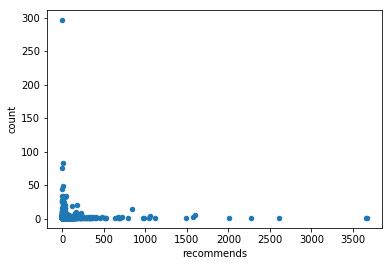

In [72]:
agg_df.plot.scatter(x='recommends', y='count');

In [73]:
medium_df[medium_df.recommends < 1].shape[0] / float(medium_df.shape[0])

0.3213660245183888

In [74]:
medium_df[medium_df.recommends < 2].shape[0] / float(medium_df.shape[0])

0.49264448336252187

### Some Machine Learning

In [75]:
split = 0
targets = (medium_df.recommends > split).astype(int)
labels = [(0, split), (split + 1, medium_df.recommends.max())]

features_train, features_test, targets_train, targets_test = train_test_split(medium_df, targets, random_state=28)
pos_weight = ( 1 - targets_train.mean()) / targets_train.mean()
pos_weight

0.47502583534274895

In [76]:
class MatrixConverter(object):
    
    def fit(self, *_): 
        return self
    
    def transform(self, X, *_):
        return sp.sparse.csc_matrix(X)

In [77]:
def evaluate(model, features, targets, classes):
    p = model.predict(features)
    print 'accuracy:', accuracy_score(p, targets)
    print classification_report(p, targets)
    cnf_matrix = confusion_matrix(targets, p)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.7247899159663865
             precision    recall  f1-score   support

          0       0.47      0.59      0.52       363
          1       0.85      0.77      0.81      1065

avg / total       0.75      0.72      0.73      1428

Confusion matrix, without normalization
Normalized confusion matrix
CPU times: user 1min 19s, sys: 1.17 s, total: 1min 20s
Wall time: 39.2 s


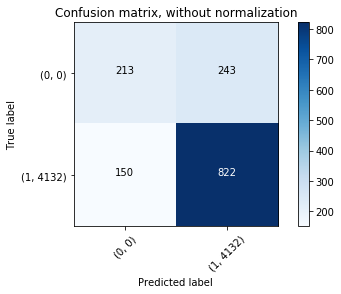

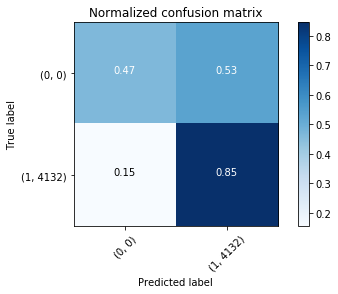

In [80]:
%%time

m_posts = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('csr_to_csc', MatrixConverter()),
    ('xgb', xgboost.XGBClassifier(max_depth=9, n_estimators=100, scale_pos_weight=pos_weight))
])

m_posts.fit(features_train.text, targets_train)
evaluate(m_posts, features_test.text, targets_test, labels)

/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.7345938375350141
             precision    recall  f1-score   support

          0       0.36      0.65      0.47       253
          1       0.91      0.75      0.82      1175

avg / total       0.81      0.73      0.76      1428

Confusion matrix, without normalization
Normalized confusion matrix
CPU times: user 1min 19s, sys: 1.1 s, total: 1min 20s
Wall time: 36.8 s


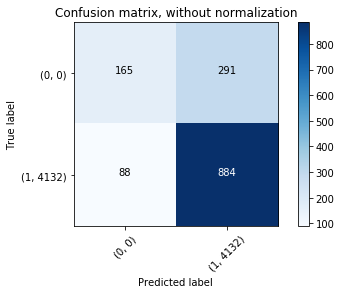

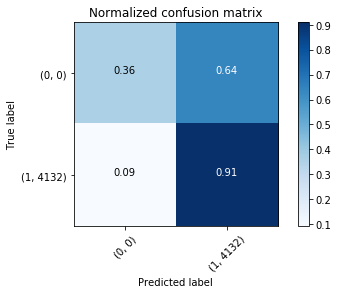

In [81]:
%%time

m_posts2 = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('csr_to_csc', MatrixConverter()),
    ('xgb', xgboost.XGBClassifier(max_depth=9, n_estimators=100, scale_pos_weight=1))
])

m_posts2.fit(features_train.text, targets_train)
evaluate(m_posts2, features_test.text, targets_test, labels)

In [82]:
def get_structure(df):
    return df[['image_count', 'reading_time', 'link_count']]

/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.6666666666666666
             precision    recall  f1-score   support

          0       0.52      0.48      0.50       492
          1       0.74      0.76      0.75       936

avg / total       0.66      0.67      0.66      1428

Confusion matrix, without normalization
Normalized confusion matrix


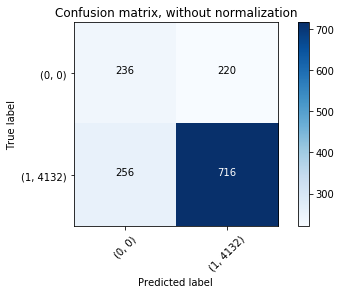

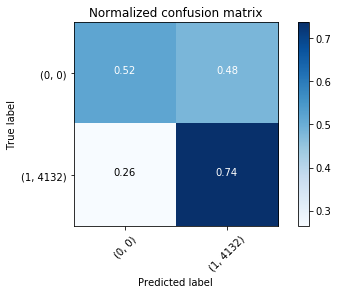

In [83]:
m_struct = xgboost.XGBClassifier(max_depth=9, n_estimators=100, scale_pos_weight=pos_weight)
m_struct.fit(get_structure(features_train), targets_train)
evaluate(m_struct, get_structure(features_test), targets_test, labels)

/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.5504201680672269
             precision    recall  f1-score   support

          0       0.55      0.37      0.44       692
          1       0.55      0.72      0.62       736

avg / total       0.55      0.55      0.54      1428

Confusion matrix, without normalization
Normalized confusion matrix
CPU times: user 2.11 s, sys: 241 ms, total: 2.35 s
Wall time: 1.56 s


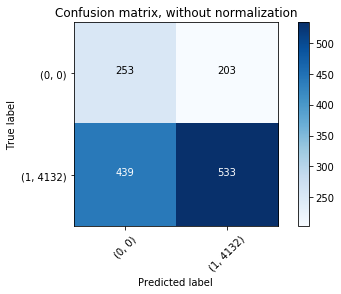

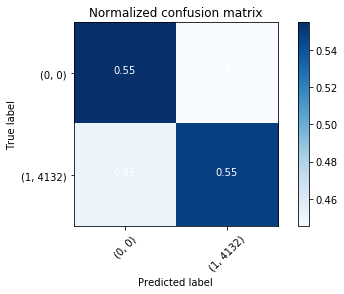

In [84]:
%%time

m_title = Pipeline([
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer(use_idf=False)),
    ('csr_to_csc', MatrixConverter()),
    ('xgb', xgboost.XGBClassifier(max_depth=9, n_estimators=100, scale_pos_weight=pos_weight))
])

m_title.fit(features_train.title, targets_train)
evaluate(m_title, features_test.title, targets_test, labels)

/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.742296918767507
             precision    recall  f1-score   support

          0       0.36      0.68      0.47       242
          1       0.92      0.75      0.83      1186

avg / total       0.83      0.74      0.77      1428

Confusion matrix, without normalization
Normalized confusion matrix


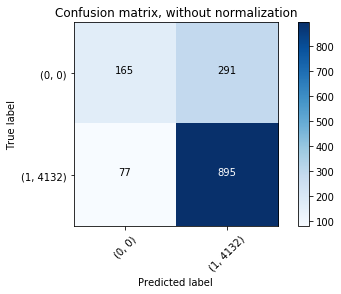

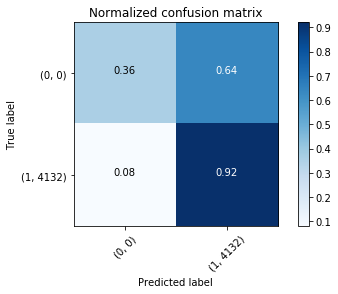

In [85]:
class Ensemble(object):
    
    def predict(self, features):
        df = pd.DataFrame({'posts': m_posts.predict(features.text), 
                           'struct': m_struct.predict(get_structure(features)), 
                           #'title': m_title.predict(features.title) 
                          })   
        return df.max(axis=1).astype(int)
        
evaluate(Ensemble(), features_test, targets_test, labels)

In [86]:
authors = pd.get_dummies(medium_df.user_username)
authors = sp.sparse.csc_matrix(authors)
authors_train, authors_test, targets_train, targets_test = train_test_split(authors, targets, test_size=0.33, random_state=42)

/Users/gabriele/.virtualenvs/datascience/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.7389920424403184
             precision    recall  f1-score   support

          0       0.28      0.70      0.40       230
          1       0.95      0.74      0.83      1655

avg / total       0.87      0.74      0.78      1885

Confusion matrix, without normalization
Normalized confusion matrix


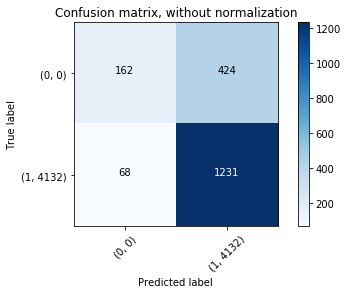

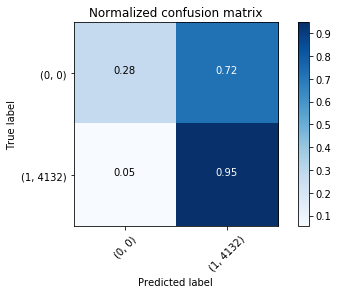

In [87]:
m_author = xgboost.XGBClassifier(max_depth=8, n_estimators=100, scale_pos_weight=pos_weight)

m_author.fit(authors_train, targets_train)
evaluate(m_author, authors_test, targets_test, labels)